<a href="https://colab.research.google.com/github/PietroSpalluto/word-2-vec/blob/main/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder, StandardScaler

from torch.utils.data import DataLoader, TensorDataset

from scipy import stats

import itertools

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/datasets/Brown_Corpus/brown.csv')
data

,filename,para_id,sent_id,raw_text,tokenized_text,tokenized_pos,label
0,cd05,0,0,"Furthermore/rb ,/, as/cs an/at encouragement/n...","Furthermore , as an encouragement to revisioni...","rb , cs at nn in nn nn , pps rb bez jj to vb c...",religion
1,cd05,0,1,The/at Unitarian/jj clergy/nns were/bed an/at ...,The Unitarian clergy were an exclusive club of...,at jj nns bed at jj nn in vbn nns -- cs at nn ...,religion
2,cd05,0,2,"Ezra/np Stiles/np Gannett/np ,/, an/at honorab...","Ezra Stiles Gannett , an honorable representat...","np np np , at jj nn in at nn , vbd ppl rb in a...",religion
3,cd05,0,3,"Even/rb so/rb ,/, Gannett/np judiciously/rb ar...","Even so , Gannett judiciously argued , the Ass...","rb rb , np rb vbd , at nn-tl md rb vb cs np ``...",religion
4,cd05,0,4,We/ppss today/nr are/ber not/* entitled/vbn to...,We today are not entitled to excoriate honest ...,ppss nr ber * vbn to vb jj nns wps vbd np to b...,religion
...,...,...,...,...,...,...,...
57335,cj14,6,3,"For/in the/at most/ap part/nn ,/, this/dt disc...","For the most part , this discussion will be co...","in at ap nn , dt nn md be vbn in nns vbn in at...",learned
57336,cj14,6,4,A/np-hl ./.-hl,A .,np-hl .-hl,learned
57337,cj14,6,5,Standard/jj-hl preparations/nns-hl and/cc-hl u...,Standard preparations and units of thyroid-sti...,jj-hl nns-hl cc-hl nns-hl in-hl jj-hl nn-hl,learned
57338,cj14,6,6,The/at international/jj unit/nn (/( u./nn )/) ...,"The international unit ( u. ) , adopted to mak...","at jj nn ( nn ) , vbn to vb jj at nn in nns in...",learned


# Preprocessing

In [4]:
docs = data['tokenized_text']
docs

0        Furthermore , as an encouragement to revisioni...
1        The Unitarian clergy were an exclusive club of...
2        Ezra Stiles Gannett , an honorable representat...
3        Even so , Gannett judiciously argued , the Ass...
4        We today are not entitled to excoriate honest ...
                               ...                        
57335    For the most part , this discussion will be co...
57336                                                  A .
57337    Standard preparations and units of thyroid-sti...
57338    The international unit ( u. ) , adopted to mak...
57339    The international unit is equipotent with the ...
Name: tokenized_text, Length: 57340, dtype: object

Lowercase

In [5]:
docs = docs.apply(lambda x: x.lower())
docs

0        furthermore , as an encouragement to revisioni...
1        the unitarian clergy were an exclusive club of...
2        ezra stiles gannett , an honorable representat...
3        even so , gannett judiciously argued , the ass...
4        we today are not entitled to excoriate honest ...
                               ...                        
57335    for the most part , this discussion will be co...
57336                                                  a .
57337    standard preparations and units of thyroid-sti...
57338    the international unit ( u. ) , adopted to mak...
57339    the international unit is equipotent with the ...
Name: tokenized_text, Length: 57340, dtype: object

Remove non words characters (punctuation, symbols and special characters)

In [6]:
docs = docs.replace(to_replace=r'[^\w\s]', value='', regex=True)
docs

0        furthermore  as an encouragement to revisionis...
1        the unitarian clergy were an exclusive club of...
2        ezra stiles gannett  an honorable representati...
3        even so  gannett judiciously argued  the assoc...
4        we today are not entitled to excoriate honest ...
                               ...                        
57335    for the most part  this discussion will be con...
57336                                                   a 
57337    standard preparations and units of thyroidstim...
57338    the international unit  u   adopted to make po...
57339    the international unit is equipotent with the ...
Name: tokenized_text, Length: 57340, dtype: object

Remove numerical digits since they do not provide significant meaning

In [7]:
docs = docs.replace(to_replace=r'\d', value='', regex=True)
docs

0        furthermore  as an encouragement to revisionis...
1        the unitarian clergy were an exclusive club of...
2        ezra stiles gannett  an honorable representati...
3        even so  gannett judiciously argued  the assoc...
4        we today are not entitled to excoriate honest ...
                               ...                        
57335    for the most part  this discussion will be con...
57336                                                   a 
57337    standard preparations and units of thyroidstim...
57338    the international unit  u   adopted to make po...
57339    the international unit is equipotent with the ...
Name: tokenized_text, Length: 57340, dtype: object

Tokenization

In [8]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

docs_tokenized = docs.apply(word_tokenize)
docs_tokenized

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0        [furthermore, as, an, encouragement, to, revis...
1        [the, unitarian, clergy, were, an, exclusive, ...
2        [ezra, stiles, gannett, an, honorable, represe...
3        [even, so, gannett, judiciously, argued, the, ...
4        [we, today, are, not, entitled, to, excoriate,...
                               ...                        
57335    [for, the, most, part, this, discussion, will,...
57336                                                  [a]
57337    [standard, preparations, and, units, of, thyro...
57338    [the, international, unit, u, adopted, to, mak...
57339    [the, international, unit, is, equipotent, wit...
Name: tokenized_text, Length: 57340, dtype: object

Stop words removal

In [9]:
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
docs_tokenized = docs_tokenized.apply(lambda x: [word for word in x if word not in stop_words])
docs_tokenized

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0        [furthermore, encouragement, revisionist, thin...
1        [unitarian, clergy, exclusive, club, cultivate...
2        [ezra, stiles, gannett, honorable, representat...
3        [even, gannett, judiciously, argued, associati...
4        [today, entitled, excoriate, honest, men, beli...
                               ...                        
57335    [part, discussion, confined, results, obtained...
57336                                                   []
57337    [standard, preparations, units, thyroidstimula...
57338    [international, unit, u, adopted, make, possib...
57339    [international, unit, equipotent, usp, unit, a...
Name: tokenized_text, Length: 57340, dtype: object

Lemmatization

In [10]:
import nltk
nltk.download('averaged_perceptron_tagger')
import nltk
nltk.download('wordnet')

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import pandas as pd

# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# define function to lemmatize tokens
def lemmatize_tokens(tokens):
    # convert POS tag to WordNet format
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    # lemmatize tokens
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    # return lemmatized tokens as a list
    return lemmas

# apply lemmatization function to column of dataframe
docs_lemmatized = docs_tokenized.apply(lemmatize_tokens)
docs_lemmatized

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0        [furthermore, encouragement, revisionist, thin...
1        [unitarian, clergy, exclusive, club, cultivate...
2        [ezra, stile, gannett, honorable, representati...
3        [even, gannett, judiciously, argue, associatio...
4        [today, entitle, excoriate, honest, men, belie...
                               ...                        
57335    [part, discussion, confine, result, obtain, si...
57336                                                   []
57337    [standard, preparation, unit, thyroidstimulati...
57338    [international, unit, u, adopt, make, possible...
57339    [international, unit, equipotent, usp, unit, a...
Name: tokenized_text, Length: 57340, dtype: object

Build a set containing words in the training corpus with a frequency greater than a selected number

In [11]:
num_train = int(len(docs_lemmatized) * 0.8)  # 80% of the paragraphs in the training set
min_term_freq = 5

# shuffle corpus and keep index (we will use it for the label when doing supervised learning)
shuffled_docs = docs_lemmatized.sample(frac=1)
indices = shuffled_docs.index
print(shuffled_docs)

# compute term frequency for each word in train
term_freq = {}
for i, sentence in enumerate(shuffled_docs):
    if i == num_train:
        break
    for word in sentence:
        term_freq[word] = term_freq.get(word, 0) + 1

# make a vocabulary including words with a frequency greater than min_term_freq
vocabulary = {word for word in term_freq.keys() if term_freq[word] >= min_term_freq}
vocabulary.add('<UNK>')  # <UNK> indicates a unknown word

print(vocabulary)
print(len(vocabulary))

43542     [hardly, deny, exaggerated, old, panorama, dead]
48624                                           [burnside]
40699    [pitiful, left, subsist, mainly, tourist, trad...
16573    [college, gross, general, experience, may, var...
29164    [organization, show, affinity, foreign, govern...
                               ...                        
38003                            [peasant, puzzle, andrei]
6736        [oughta, able, build, new, house, contraption]
7679                   [really, crucify, nail, yard, loss]
55536    [instance, two, presidential, commission, high...
5834     [sba, loan, may, make, small, manufacturer, sm...
Name: tokenized_text, Length: 57340, dtype: object
{'recording', 'leveling', 'beneath', 'hostess', 'ultimately', 'dwight', 'urgent', 'uh', 'downward', 'bail', 'perfection', 'dei', 'latent', 'sam', 'gear', 'wheat', 'chauffeur', 'lust', 'slat', 'batista', 'adoniram', 'wardrobe', 'wholly', 'developer', 'kafka', 'struck', 'muddy', 'passage', 'swore', 'h

# Neural Probabilistic Language Model data preparation and model building and training

Making n-grams from sentences

In [12]:
from sklearn.preprocessing import LabelEncoder

# if the word is not in the vocabulary build using the training set it is replaced with <UNK>
def replace_unknown_word(word, vocabulary):
    if word in vocabulary:
        return word
    else:
        return '<UNK>'

# return the ids for each word in the n-gram
def get_ngram_ids(ngram, encoder):
    return encoder.transform(ngram)


n_grams_len = 10  # n-gram length
min_len = n_grams_len  # minimum sentence length

encoder = LabelEncoder()
word_ids = encoder.fit_transform(list(vocabulary))  # encode words into ids
print(word_ids)

n_grams_train = []
n_grams_test = []
for i, sentence in enumerate(shuffled_docs):
    # skip sentences with less words than min_len
    if len(sentence) < min_len:
        continue
    # iterate through the sentence and build n-grams (the last word is the word to predict)
    for j, word in enumerate(sentence):
        if j < len(sentence) - (n_grams_len-1):
            if i <= num_train:
                n_grams_train.append([replace_unknown_word(sentence[j+k], vocabulary) for k in range(n_grams_len) if k < n_grams_len])
            else:
                n_grams_test.append([replace_unknown_word(sentence[j+k], vocabulary) for k in range(n_grams_len) if k < n_grams_len])

# numpy array conversion
n_grams_train = np.array(n_grams_train)
n_grams_test = np.array(n_grams_test)

# replace words with ids
for i in range(n_grams_len):
    n_grams_train[:, i] = encoder.transform(n_grams_train[:, i])
    n_grams_test[:, i] = encoder.transform(n_grams_test[:, i])

print(n_grams_train.shape)
print(n_grams_test.shape)

[7059 4999  851 ... 3335 1690 4061]
(118417, 10)
(29154, 10)


Split X and y

In [13]:
n_grams_train = np.array(n_grams_train, dtype=int)
n_grams_test = np.array(n_grams_test, dtype=int)

X_train = n_grams_train[:, 0:n_grams_len-1]
y_train = n_grams_train[:, -1]
X_test = n_grams_test[:, 0:n_grams_len-1]
y_test = n_grams_test[:, -1]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(118417, 9)
(118417,)
(29154, 9)
(29154,)


Convert to torch tensor and make a torch Dataset


In [14]:
import torch

batch_size = 1024

X_train = torch.LongTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.LongTensor(X_test)
y_test = torch.LongTensor(y_test)
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_data = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Build NPLM model (based on Bengio's A Neural Probabilistic Language Model)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NPLM(nn.Module):
    def __init__(self, vocabulary_size, embedding_dim, hidden_dim, context_size):
        super(NPLM, self).__init__()
        self.train_losses = []
        self.eval_losses = []

        self.embedding = nn.Embedding(vocabulary_size, embedding_dim)
        # the hidden layer takes in input a number of embeddings equal to the context size
        self.hidden_layer = nn.Linear(context_size * embedding_dim, hidden_dim)
        self.hidden_layer_2 = nn.Linear(hidden_dim, vocabulary_size, bias=False)

        # self.criterion = nn.NLLLoss()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        # concatenation of the embeddings of n-1 words of the n-gram
        emb = self.embedding(x).reshape(x.shape[0], -1)
        out = torch.tanh(self.hidden_layer(emb))
        out = self.hidden_layer_2(out)
        probs = F.softmax(out, dim=1)

        return probs

    def loss(self, output, target):
        return self.criterion(target, output)


In [21]:
# NPLM parameters
vocab_size = len(vocabulary)
embedding_dim = 256
hidden_dim = 1024
context_size = n_grams_len - 1
learning_rate = 0.0001
num_epochs = 500

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = NPLM(vocab_size, embedding_dim, hidden_dim, context_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model = model.to(device)

print('Model')
print(model)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable parameters: {:,}'.format(trainable_params))
print('Optimizer')
print(optimizer)

Model
NPLM(
  (embedding): Embedding(9571, 256)
  (hidden_layer): Linear(in_features=2304, out_features=1024, bias=True)
  (hidden_layer_2): Linear(in_features=1024, out_features=9571, bias=False)
  (criterion): CrossEntropyLoss()
)
Trainable parameters: 14,611,200
Optimizer
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


In [22]:
for epoch in range(num_epochs):
    # train loop
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(train_data):
        input = batch[0].to(device)
        target = batch[1].to(device)

        output = model(input)

        loss = model.criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # print loss of some batches
        if i % 100 == 0:
            print('Epoch [{}/{}], batch {}, batch loss: {}'.format(epoch+1, num_epochs, i, loss.item()))

    epoch_loss = epoch_loss / len(train_data)
    model.train_losses.append(epoch_loss)
    print('Epoch [{}/{}], epoch mean loss: {}'.format(epoch+1, num_epochs, epoch_loss))

    # evaluation loop
    model.eval()
    eval_loss = 0
    for batch in test_data:
        input = batch[0].to(device)
        target = batch[1].to(device)

        output = model(input)

        loss = model.criterion(output, target)

        eval_loss += loss.item()

    eval_loss = eval_loss / len(test_data)
    model.eval_losses.append(eval_loss)
    print('Epoch [{}/{}], evaluation loss: {}'.format(epoch+1, num_epochs, eval_loss))

Epoch [1/500], batch 0, batch loss: 9.16649341583252
Epoch [1/500], batch 100, batch loss: 9.10129451751709
Epoch [1/500], epoch mean loss: 9.120501378486896
Epoch [1/500], evaluation loss: 9.088843444298053
Epoch [2/500], batch 0, batch loss: 9.104970932006836
Epoch [2/500], batch 100, batch loss: 9.079690933227539
Epoch [2/500], epoch mean loss: 9.099397149579278
Epoch [2/500], evaluation loss: 9.080929854820514
Epoch [3/500], batch 0, batch loss: 9.105002403259277
Epoch [3/500], batch 100, batch loss: 9.07713508605957
Epoch [3/500], epoch mean loss: 9.089867567193918
Epoch [3/500], evaluation loss: 9.072750683488517
Epoch [4/500], batch 0, batch loss: 9.080291748046875
Epoch [4/500], batch 100, batch loss: 9.089437484741211
Epoch [4/500], epoch mean loss: 9.084033431677982
Epoch [4/500], evaluation loss: 9.068731176442114
Epoch [5/500], batch 0, batch loss: 9.068252563476562
Epoch [5/500], batch 100, batch loss: 9.08470630645752
Epoch [5/500], epoch mean loss: 9.081093344195136
Epoc

Plot losses

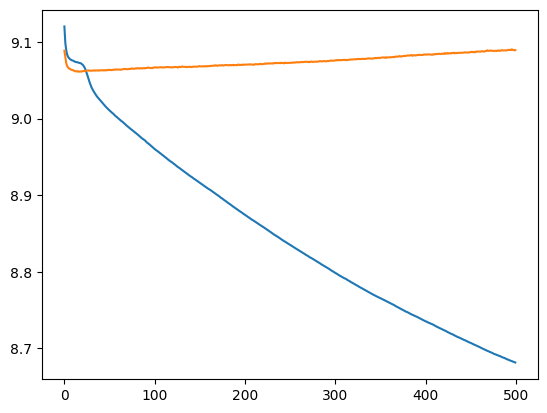

In [23]:
plt.plot(model.train_losses)
plt.plot(model.eval_losses)
plt.show()

Save and load model

In [25]:
torch.save(model.state_dict(), '/content/drive/MyDrive/datasets/Brown_Corpus/nplm_model.pt')

We use the embeddings to compute similarities between words

In [27]:
words = {('socialist', 'republic'), ('cat', 'dog'), ('dog', 'republic'), ('socialist', 'cat')}

cos = nn.CosineSimilarity(dim=0)

lm_similarities = {}
for word_pairs in words:
    w1 = word_pairs[0]
    w2 = word_pairs[1]
    words_tensor = torch.LongTensor(np.array([encoder.transform([w1]), encoder.transform([w2])]))
    words_tensor = words_tensor.to(device)
    # get word embeddings from the best model
    words_embeds = model.embedding(words_tensor)
    # calculate cosine similarity between word vectors
    sim = cos(words_embeds[0][0], words_embeds[1][0])
    lm_similarities[word_pairs] = sim.item()

print(lm_similarities)

{('socialist', 'cat'): 0.0028149187564849854, ('dog', 'republic'): -0.014645600691437721, ('socialist', 'republic'): -0.11175817251205444, ('cat', 'dog'): -0.048882946372032166}


<ipython-input-27-25ba1d808e12>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  words_tensor = torch.LongTensor([encoder.transform([w1]), encoder.transform([w2])])


Load model

In [20]:
vocab_size = 9571
embedding_dim = 256
hidden_dim = 1024
context_size = n_grams_len - 1
learning_rate = 0.0001
num_epochs = 500

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = NPLM(vocab_size, embedding_dim, hidden_dim, context_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model = model.to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/datasets/Brown_Corpus/nplm_model.pt'))

<All keys matched successfully>

In [22]:
model.embedding.weight.shape

torch.Size([9571, 256])

Project words into a 2D space to visualize them

In [ ]:
from sklearn.manifold import Isomap, TSNE

embeddings = model.embedding.weight

# dimensionality reduction
isomap = Isomap(n_components=2)
# tsne = TSNE(n_components=2)
embeddings_2d = isomap.fit_transform(embeddings.detach().cpu().numpy())
# embeddings_2d = tsne.fit_transform(embeddings.detach().cpu().numpy())

In [ ]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.1)
plt.show()

# Word2Vec data preparation and model building and training

In [29]:
from sklearn.preprocessing import LabelEncoder

# if the word is not in the vocabulary build using the training set it is replaced with <UNK>
def replace_unknown_word(word, vocabulary):
    if word in vocabulary:
        return word
    else:
        return '<UNK>'

# return the ids for each word in the n-gram
def get_ngram_ids(ngram, encoder):
    return encoder.transform(ngram)


context_len = 11  # n-gram length
min_len = context_len  # minimum sentence length

encoder = LabelEncoder()
word_ids = encoder.fit_transform(list(vocabulary))  # encode words into ids
print(word_ids)

context_train = []
context_test = []
for i, sentence in enumerate(shuffled_docs):
    # skip sentences with less words than min_len
    if len(sentence) < min_len:
        continue
    # iterate through the sentence and build n-grams (the last word is the word to predict)
    for j, word in enumerate(sentence):
        if j < len(sentence) - (context_len-1):
            if i <= num_train:
                context_train.append([replace_unknown_word(sentence[j+k], vocabulary) for k in range(context_len) if k < context_len])
            else:
                context_test.append([replace_unknown_word(sentence[j+k], vocabulary) for k in range(context_len) if k < context_len])

# numpy array conversion
context_train = np.array(context_train)
context_test = np.array(context_test)

# replace words with ids
for i in range(context_len):
    context_train[:, i] = encoder.transform(context_train[:, i])
    context_test[:, i] = encoder.transform(context_test[:, i])

print(context_train.shape)
print(context_test.shape)

[7059 4999  851 ... 3335 1690 4061]
(99587, 11)
(24434, 11)


Split X and y for CBOW and Skip-gram

In [37]:
arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Use slicing to take all elements except the 5th element (which has index 4)
result = np.concatenate([arr[:4], arr[5:]])

print(result)

[ 1  2  3  4  6  7  8  9 10]


In [ ]:
context_train = np.array(context_train, dtype=int)
context_test = np.array(context_test, dtype=int)

# CBOW splitting (usually the context length is an odd number)
X_train = context_train[:, 0:context_len-1]
y_train = context_train[:, -1]
X_test = context_test[:, 0:context_len-1]
y_test = context_test[:, -1]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)